In [1]:
import os
import sys
import fnmatch

import torch
from torchviz import make_dot

import numpy as np

import GPy
import tables

import emcee
import corner
import joblib

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.interpolate

from ps_eor import datacube, pspec, psutil, simu, fitutil, fgfit

import ml_gpr

import astropy.units as u
import astropy.constants as const
import astropy.stats as astats

mpl.rcParams['image.cmap'] = 'viridis'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['axes.grid'] = True

# Purpose of this notebook

- Load 21cmFast image cubes 
- produce power-spectra for each cube
- normalize the power-spectra
- train the VAE on this data set

# Define some common variables here

In [8]:
kbins = np.logspace(np.log10(0.05), np.log10(2.5), 13)
k_mean = np.array([0.05730528, 0.08320909, 0.11519442, 0.16067338, 0.22356231,
                   0.30937082, 0.42911561, 0.59454327, 0.82347184, 1.10628762,
                   1.54903247, 2.11011604])

# Generate power-spectra from the images cubes and save them locally for later use

If have your own simulations, otherwise jump to the section "Loading a selection of power-spectra for ML"

In [9]:
# Define here some constants and the directory containing the simulation and power-spectra

ps_dir = '/net/node128/data/users/lofareor/nenufar/21cmFast/cov/simu_400mpc'
models_21cm_dir = '/net/node128/data/users/lofareor/nenufar/21cmFast/Programs/models'
models_21cm_dir = '/net/node128/data/users/lofareor/nenufar/21cmFast/simu_400mpc'

simu_all_ps_dir = 'simu/21cmFAST_3params_400mpc'

n_pix = 200
box_size_cmpc = 400

zetas = np.arange(10, 250, 5)
tvirs = np.arange(4, 6, 0.1)
rmfps = np.arange(5, 25, 2)
all_params = np.array(np.meshgrid(zetas, tvirs, rmfps)).reshape(3, -1).T


def get_ps(z, zeta, tvir, rmfp):
    return pspec.SphericalPowerSpectra.load_from_txt(f'{ps_dir}/ps_z{z}_zeta{zeta:.1f}_tvir{tvir:.1f}_rmfp{rmfp:.1f}.txt')


def save_ps(ps3d, z, zeta, tvir, rmfp):
    ps3d.save_to_txt(f'{ps_dir}/ps_z{z}_zeta{zeta:.1f}_tvir{tvir:.1f}_rmfp{rmfp:.1f}.txt')


def get_vis_cube(z, zeta, tvir, rmfp):
    return datacube.CartDataCube.load(f'{models_21cm_dir}/box_z{z:.0f}_zeta{zeta:.2f}_tvir{tvir:.2f}_rmfp{rmfp:.2f}')

# Function to produce the power-spectra from the image cube. It should be run only once
def generate_all_ps(z, all_params):
    pr = psutil.progress_report(all_params.shape[0])

    for i, (zeta, tvir, rmfp) in enumerate(all_params):
        pr(i)
#         if not(os.path.exists(f'{models_21cm_dir}/box_z{z:.1f}_zeta{zeta:.2f}_tvir{tvir:.2f}_rmfp{rmfp:.2f}')):
#             continue
        i_cube = get_vis_cube(z, zeta, tvir, rmfp)
        ps_build = pspec.PowerSpectraBuilder()
        ps_gen = ps_build.get(i_cube, fmhz_range=[i_cube.freqs.min() * 1e-6, i_cube.freqs.max() * 1e-6],
                              du=10, umax=1000, umin=30, rmean_freqs=False, ps2d_pos_only=False, 
                              window_fct='hann')

        ps3d = ps_gen.get_ps3d(kbins, i_cube)
        save_ps(ps3d, z, zeta, tvir, rmfp)


def get_all_ps(z, step_parameters=1, shuffle=True):
    ps3d = get_ps(z, 100, 5, 13)

    zetas = np.arange(10, 250, step_parameters * 5)
    tvirs = np.arange(4, 6, step_parameters * 0.1)
    rmfps = np.arange(5, 25, step_parameters * 2)
    all_params = np.array(np.meshgrid(zetas, tvirs, rmfps)).reshape(3, -1).T

    # Load all 1D normalized covariance
    all_ps = np.array([get_ps(z, zeta, tvir, rmfp).data for zeta, tvir, rmfp in all_params])

    # shuffle the set
    np.random.shuffle(all_ps)

    # discard PS which are too low
    idx = all_ps.sum(axis=1) > 1e-4
    all_ps = all_ps[idx]
    all_params = all_params[idx]

    # normalize it so that it is flatter (multiply by k ** -1) and between 0 and 1
    all_ps = all_ps / (ps3d.k_mean ** -3 * all_ps).sum(axis=1)[:, None]
    all_ps = all_ps * ps3d.k_mean ** -1
    norm_factor = all_ps.max()
    all_ps = all_ps / norm_factor

    return all_ps, all_params, norm_factor

In [ ]:
# Generate the PS -- should be done only once per reshift

z = 10.1
generate_all_ps(z)

In [ ]:
all_ps3d = {}
pr = psutil.progress_report(all_params.shape[0])

for i, (zeta, tvir, rmfp) in enumerate(all_params):
    pr(i)
    all_ps3d[(zeta, tvir, rmfp)] = []
    for z in np.arange(6, 25):
        i_cube = get_vis_cube(z, zeta, tvir, rmfp)
        ps_build = pspec.PowerSpectraBuilder()
        ps_gen = ps_build.get(i_cube, fmhz_range=[i_cube.freqs.min() * 1e-6, i_cube.freqs.max() * 1e-6],
                              du=10, umax=1000, umin=30, rmean_freqs=False, window_fct='hann')

        ps3d = ps_gen.get_ps3d([0.08, 0.12], i_cube)
        all_ps3d[(zeta, tvir, rmfp)].append(ps3d.data[0])

In [3544]:
# Save the PS to numpy array locally here -- should be done only once per reshift

z = 10.1
all_ps, all_params, norm_factor = get_all_ps(z, 1)

np.save(simu_all_ps_dir + f'/all_ps_21cmFast_z{z}_400Mpc', all_ps)
np.save(simu_all_ps_dir + f'/all_params_21cmFast_z{z}_400Mpc', all_params)

# Check the Power Spectra training set

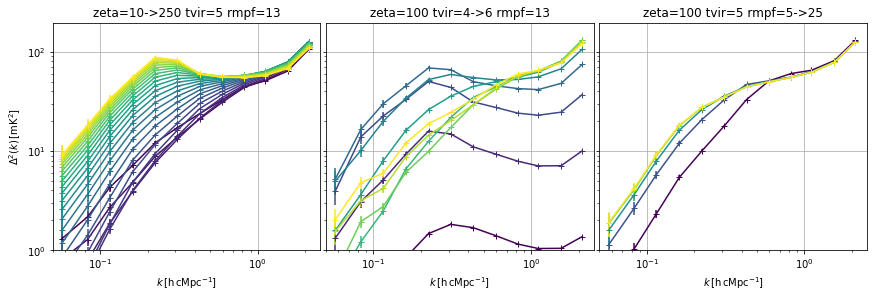

In [19]:
import warnings
warnings.filterwarnings(action="error", category=np.ComplexWarning)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

colors = plt.cm.viridis(np.linspace(0, 1, len(zetas)))

for c, zeta in zip(colors, zetas):
    ps = get_ps(z, zeta, 5, 13)
    ps.plot(ax=ax1, c=c)

colors = plt.cm.viridis(np.linspace(0, 1, len(tvirs)))

for c, tv in zip(colors, tvirs):
    ps = get_ps(z, 100, tv, 13)
    ps.plot(ax=ax2, c=c)

colors = plt.cm.viridis(np.linspace(0, 1, len(rmfps)))

for c, rm in zip(colors, rmfps):
    ps = get_ps(z, 100, 5, rm)
    ps.plot(ax=ax3, c=c)

ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_title('zeta=10->250 tvir=5 rmpf=13')
ax2.set_title('zeta=100 tvir=4->6 rmpf=13')
ax3.set_title('zeta=100 tvir=5 rmpf=5->25')

ax1.set_ylim(ymin=1e0)
fig.tight_layout(pad=0.2)


# Loading a selection of power-spectra for ML

(509, 12) (5883, 12)


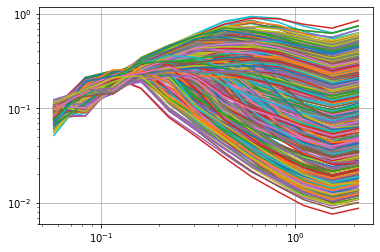

In [4]:
simu_all_ps_dir = 'simu/21cmFAST_3params_400mpc'

k_mean = np.array([0.05730528, 0.08320909, 0.11519442, 0.16067338, 0.22356231,
                   0.30937082, 0.42911561, 0.59454327, 0.82347184, 1.10628762,
                   1.54903247, 2.11011604])

def get_all_ps_cache(z):
    all_ps = np.load(simu_all_ps_dir + f'/all_ps_21cmFast_z{z}_400Mpc.npy')
    all_params = np.load(simu_all_ps_dir + f'/all_params_21cmFast_z{z}_400Mpc.npy')

    return all_ps, all_params

def select_params(all_params, num):
    # Function to 
    n_f, n_p  = all_params.shape
    u_params = [np.unique(all_params[:, k]) for k in range(n_p)]
    n_u_p = np.array([len(k) for k in u_params])
    f = (n_f / num) ** (1 / 3)
    n_sel_u_p = np.clip(np.round(n_u_p / f), 2, n_f).astype(int)
    n_u_p, n_sel_u_p

    u_params_selected = [k[np.linspace(0, len(k) - 1, n).astype(int)] for k, n in zip(u_params, n_sel_u_p)]
    idx_all_params_selected = np.prod([np.in1d(all_params[:, i], k) for i, k in enumerate(u_params_selected)], axis=0)
    idx_all_params_selected = idx_all_params_selected.astype(bool)

    return idx_all_params_selected

def get_data(all_ps, all_params, n_train):
    idx_train = select_params(all_params, n_train)
    mask_train = np.zeros(all_ps.shape[0], dtype=bool)
    mask_train[idx_train] = 1

    return all_ps[mask_train], all_ps[~mask_train], all_params[mask_train], all_params[~mask_train]

z = 8.3
all_ps, all_params = get_all_ps_cache(z)

train_data, test_data, train_params, test_params = get_data(all_ps, all_params, 500)
print(train_data.shape, test_data.shape)

plt.plot(k_mean, train_data.T)
plt.yscale('log')
plt.xscale('log')

# VAE with pytorch

In [5]:
batch_size = 64
epochs = 2000
beta = 1e-4
latent_dim = 2
z = 10.1

train_data, test_data, train_params, test_params = get_data(all_ps, all_params, 500)
print(len(train_data), len(test_data))

# training and validation data loaders
train_loader = ml_gpr.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = ml_gpr.DataLoader(test_data, batch_size=batch_size, shuffle=False)

model = ml_gpr.BetaVAE(train_data.shape[1], latent_dim, loss_type='W', beta=beta, hidden_dims=[20, 20, 20]).double()
optimizer = ml_gpr.optim.Adagrad(model.parameters(), lr_decay=1e-5, lr=0.02)

fitter = ml_gpr.VAEFitter(model, optimizer, k_mean)

509 5883


In [6]:
fitter.train(epochs, train_loader, val_loader)

VAE Fitter 100% (2000 of 2000) [||||||||||||||||] Time:  0:18:22 Loss: 0.000808


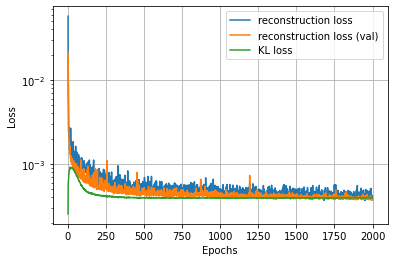

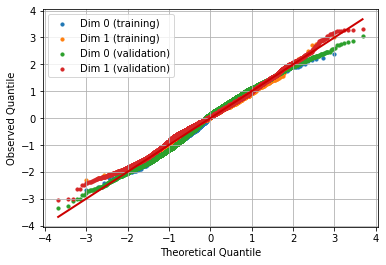

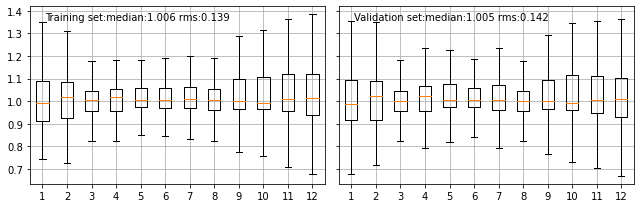

In [7]:
vae_res = ml_gpr.FitterResult(fitter, train_loader, val_loader)

vae_res.plot_loss()
vae_res.plot_latent_qq()
vae_res.plot_ratio()
pass

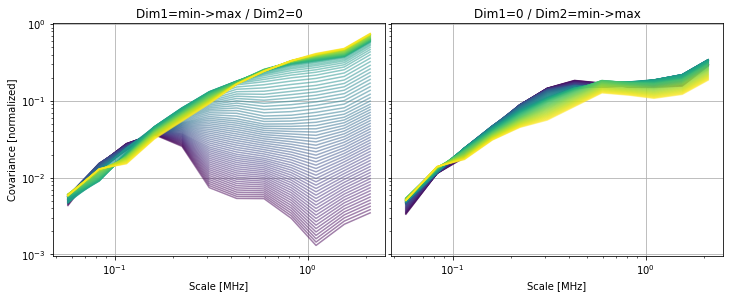

<Figure size 432x288 with 0 Axes>

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

n = 100
x1 = np.linspace(-3, 3, n)
colors = plt.cm.viridis(np.linspace(0, 1, n))
for i in range(n):
    ax1.plot(k_mean, k_mean * fitter.decode([x1[i], 0]), alpha=0.5, c=colors[i])

plt.figure()
x2 = np.linspace(-3, 3, n)
for i in range(n):
    ax2.plot(k_mean, k_mean * fitter.decode([0, x2[i]]), alpha=0.5, c=colors[i])

ax1.set_ylabel('Covariance [normalized]')
ax1.set_xlabel('Scale [MHz]')
ax2.set_xlabel('Scale [MHz]')

ax1.set_title('Dim1=min->max / Dim2=0')
ax2.set_title('Dim1=0 / Dim2=min->max')

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')

fig.tight_layout(pad=0.2)

# VAE with different numbers of samples

In [40]:
z = 10.1
all_ps, all_params = get_all_ps_cache(z)

model_vae_dir = 'VAE_models/'
model_pca_dir = 'PCA_models/'

In [47]:
n_ss = [50, 500, 5000]
# n_ss = [500, 1500, 5000]

batch_size = 128
epochs = 2000
beta = 1e-4
latent_dim = 2

vae_results = []
pca_results = []

for n_s in n_ss:
    train_data, test_data, train_params, test_params = get_data(all_ps, all_params, n_s)

    n = len(train_data)
    n_batch = max(1, np.round(n / batch_size))
    c_batch_size = int(n / n_batch)
    drop_last = bool((n_batch * c_batch_size) < n)

    # training and validation data loaders
    train_loader = ml_gpr.DataLoader(train_data, batch_size=c_batch_size, shuffle=True, drop_last=drop_last)
    val_loader = ml_gpr.DataLoader(test_data, batch_size=c_batch_size, shuffle=False)
    print(f'Training samples: {len(train_data)}, validation samples: {len(test_data)}, batch size: {c_batch_size}')

    model = ml_gpr.BetaVAE(train_data.shape[1], latent_dim, loss_type='W', beta=beta,
                           hidden_dims=[20, 20, 20]).double()
#     optimizer = ml_gpr.optim.AdamW(model.parameters(), lr=lr)
    optimizer = ml_gpr.optim.Adagrad(model.parameters(), lr_decay=1e-5, lr=0.02)

    fitter = ml_gpr.VAEFitter(model, optimizer, k_mean)
    fitter.train(epochs, train_loader, val_loader)

    joblib.dump(fitter, model_vae_dir + f'vae_21cmFAST_3params_{latent_dim}_z{z}_n{n_s}_med_beta.pt')

    vae_results.append(ml_gpr.FitterResult(fitter, train_loader, val_loader))

    pca_fitter = ml_gpr.PCAFitter(latent_dim, k_mean)
    pca_fitter.train(train_data)

    joblib.dump(pca_fitter, model_pca_dir + f'pca_21cmFAST_3params_{latent_dim}_z{z}_n{n_s}.pkl')

    pca_results.append(ml_gpr.FitterResult(pca_fitter, train_loader, val_loader))

Training samples: 60, validation samples: 8125, batch size: 60


VAE Fitter 100% (2000 of 2000) [||||||||||||||||] Time:  0:06:19 Loss: 0.000756


Training samples: 516, validation samples: 7669, batch size: 129


VAE Fitter 100% (2000 of 2000) [|||||||||||||||||] Time:  0:04:16 Loss: 0.00075


Training samples: 4774, validation samples: 3411, batch size: 129


VAE Fitter 100% (2000 of 2000) [|||||||||||||||||] Time:  0:05:06 Loss: 0.00069


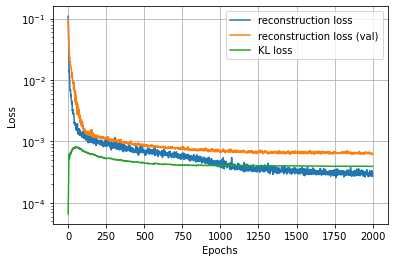

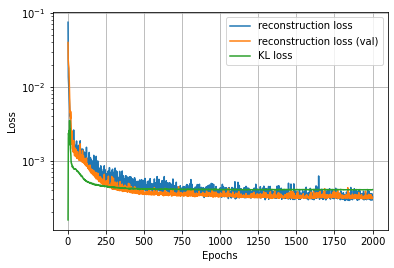

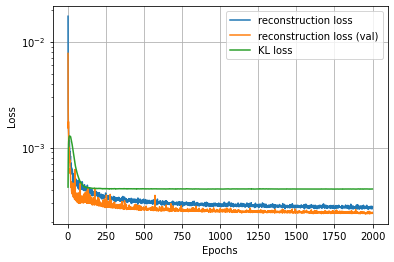

In [52]:
z = 10.1
n_ss = [50, 500, 5000]

vae_results = [ml_gpr.FitterResult(ml_gpr.VAEFitter.load(model_vae_dir + f'vae_21cmFAST_3params_2_z{z}_n{n_s}_med_beta.pt'), 
                                   train_loader, val_loader) for n_s in n_ss]
for vae_res in vae_results:
    vae_res.plot_loss()
#     vae_res.plot_latent_qq()
pass